<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1, вариант №7</center>

## Тема 14 (часть 1). Метод конечных разностей решения краевых задач для ОДУ  

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array, linspace
from scipy.linalg import solve_banded
from IPython.display import display, Latex, HTML
from sympy import Symbol, latex, init_printing, dsolve, sqrt, Eq, sympify, exp

init_printing()

# План

1. Постановка краевой задачи для ОДУ
2. Точные методы
    - Метод Грина
3. Приближённые (численные) методы
    - Метод конечных разностей
4. Приближённо-аналитические методы (проекционные)
    - Метод Галёркина
    - Метод коллокации в подобластях
    - Метод коллокации в точках 
    - Метод коллокации в чебышевских узлах

$$\mathscr{F}\left(x, y, y', y''\right)=0, x\in\left(a;b\right),$$

Будем рассматривать краевую задачу для линейного ОДУ 2-го порядка с линейными краевыми условиями:

$$p_0(x) y'' + p_1 (x) y' + p_2(x) y = f(x), x\in(a; b),$$

$$ \alpha_0 y(a) + \alpha_1 y'(a) = A; \beta_0 y(b) + \beta_1 y'(b) = B.$$

In [2]:
x = Symbol('x')
y = Symbol('y')(x)
p0 = 4 * x ** 2
p1 = -4 * x
p2 = -5 * x**0
f = -4 * sqrt(x)

a, b, N = 1, 2, 10
alpha0, alpha1, A = 2, 0, 5
beta0, beta1, B = 1, 4, 2**0.5
# boundary conditions all together
bcs = {'alpha0': alpha0, 'alpha1': alpha1, 'A': A,
       'beta0':   beta0, 'beta1':   beta1, 'B': B}

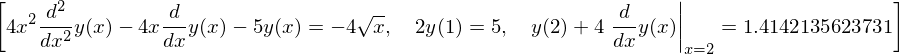

In [3]:
[Eq(p0 * y.diff(x, 2) + p1 * y.diff(x) + p2 * y, f), 
 Eq(alpha0 * y.subs(x, a) + alpha1 * y.diff(x).subs(x, a), A),
 Eq(beta0 * y.subs(x, b) + beta1 * y.diff(x).subs(x, b), B)]

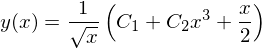

In [4]:
dsolve(p0*y.diff(x, 2) + p1*y.diff(x) + p2*y - f, y)

In [5]:
y_true = sqrt(x) / 2 + 2 / sqrt(x)

# Метод конечных разностей 

$$y_0' = \frac{-3 y_0 + 4 y_1 - y_2}{2h}$$
$$ (2h\alpha_0 - 3\alpha_1)y_0 + 4\alpha_1y_1 - \alpha_1 y_2 = 2Ah$$

$$y_N' = \frac{y_{N-2} - 4 y_{N-1} + 3 y_N}{2h}$$
$$ \beta_1 y_{N-2} - 4 \beta_1 y_{N-1} + (2\beta_0h + 3\beta_1) y_N = 2Bh$$

In [2]:
def solve_2linbvp(p0, p1, p2, f, x, bcs, method, ret_coefs=False):
    P0, P1, P2, F = p0(x), p1(x), p2(x), f(x)
    alpha0 = bcs['alpha0']; alpha1 = bcs['alpha1']; A = bcs['A']
    beta0 = bcs['beta0']; beta1 = bcs['beta1']; B = bcs['B']
    
    # coefs - coefficients of linear system with tridiagonal matrix in a
    # human-attractive form: first columns is a_k, second - b_k,
    # third - c_k; b - right-hand-side of the system
    coefs = np.zeros((N+1, 3), dtype=np.float64); b = F * h**2
    coefs[1:-1, 0] =    P0[1:-1] -  h/2 * P1[1:-1] # a_k - coefficients of y_{k-1}
    coefs[1:-1, 1] = -2*P0[1:-1] + h**2 * P2[1:-1] # b_k - coefficients of y_k
    coefs[1:-1, 2] =    P0[1:-1] +  h/2 * P1[1:-1] # c_k - coefficients of y_{k+1}
    
    if method == 'first order':
        # left
        coefs[0, 1] = alpha0*h - alpha1; coefs[0, 2] = alpha1; b[0] = A*h
        # right
        coefs[N, 0] = -beta1; coefs[N, 1] = beta0*h + beta1; b[N] = B*h  
    elif method == 'second order':
        # left
        temp0 = array([[2*h*alpha0-3*alpha1, 4*alpha1, -alpha1, 2*h*A], np.r_[coefs[1, :], b[1]]])
        temp0[0] = temp0[0] + temp0[1] * alpha1 / temp0[1, 2]
        coefs[0, 1:] = temp0[0, :2]; b[0] = temp0[0, 3]
        # right
        tempN = array([[beta1, -4*beta1, 2*h*beta0+3*beta1, 2*h*B], np.r_[coefs[N-1, :], b[N-1]]])
        tempN[0] = tempN[0] - tempN[1] * beta1 / tempN[1, 0]
        coefs[N, :2] = tempN[0, 1:3]; b[N] = tempN[0, 3]    
    elif method == 'second order taylor':
        # left
        coefs[0, 1] = alpha0*P0[0] + alpha1*(-P0[0]/h - P1[0]/2+h*P2[0]/2)
        coefs[0, 2] = alpha1*(P0[0]/h+P1[0]/2) 
        b[0] = A*P0[0] + h*F[0]*alpha1/2
        # right
        coefs[N, 0] = beta1*(-P0[N]/h+P1[N]/2)
        coefs[N, 1] = beta0*P0[N] + beta1*(P0[N]/h-P1[N]/2-h*P2[N]/2)
        b[N] = B*P0[N] - h*beta1*F[N]/2
    else:
        raise ValueError("Inappropriate value for 'method' argument!")

    # the same, but in a form that fits for 'solve_banded' method
    ab = np.zeros((3, N+1), dtype=np.float64)
    ind2 = array([0, 1]); ind3 = array([0, 1, 2])
    ab[ind2, 1-ind2] = coefs[0, 2:0:-1]    
    for k in range(1, N):
        ab[ind3, k+1-ind3] = coefs[k, ::-1]
    ab[1+ind2, N-ind2] = coefs[N, -2::-1]
    
    # solving our tridiagonal system
    Y = solve_banded((1, 1), ab, b)  
    
    if ret_coefs:
        return Y, coefs, b
    else:
        return Y

In [4]:
def plot_results(X, Y, y_true):
    
    a, b = X[0], X[-1]
    x_grid = linspace(a, b, 101)
    #y_grid = array([y_true.subs(x, xk) for xk in x_grid])
    #Y_err = array([abs(y_true.subs(x, X[k]) - Y[k]) for k in range(len(X))])
    
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(x_grid, y_grid, color='black', alpha=0.6, label='$y(x)$')
    axes[0].scatter(X, Y, color='red', s=3, label='$y_k$')
    axes[1].plot(X, Y_err, color='black', alpha=0.75, label='$\\varepsilon_k$')
    axes[0].legend(); axes[1].legend()
    plt.tight_layout();

def display_results_table(y_true, *args):

    X = linspace(a, b, N+1)
    Y = np.zeros((N+1, 3))
    Y_true = array([y_true.subs(x, xk) for xk in X])
    
    for i, method in zip(range(3), ['first order', 'second order', 'second order taylor']):
        Y[:, i] = solve_linear_2nd_order_de(*args, method)        
               
    res = pd.DataFrame(data='', index=pd.Index([*X, '$\max \\varepsilon_i$'], name='$x_k$'),
                       columns=pd.Index(['1 способ', '2 способ', '3 способ'], name='Способ аппроксимации\\n краевых условий'))
    res.iloc[:-1, :] = Y
    max_err = np.abs(Y-Y_true.reshape((-1, 1))).max(axis=0)
    res.iloc[-1, :] = ['%.2e' % err for err in max_err]
    
    display(HTML(res.to_html().replace("\\n","<br>")))

<IPython.core.display.Javascript object>


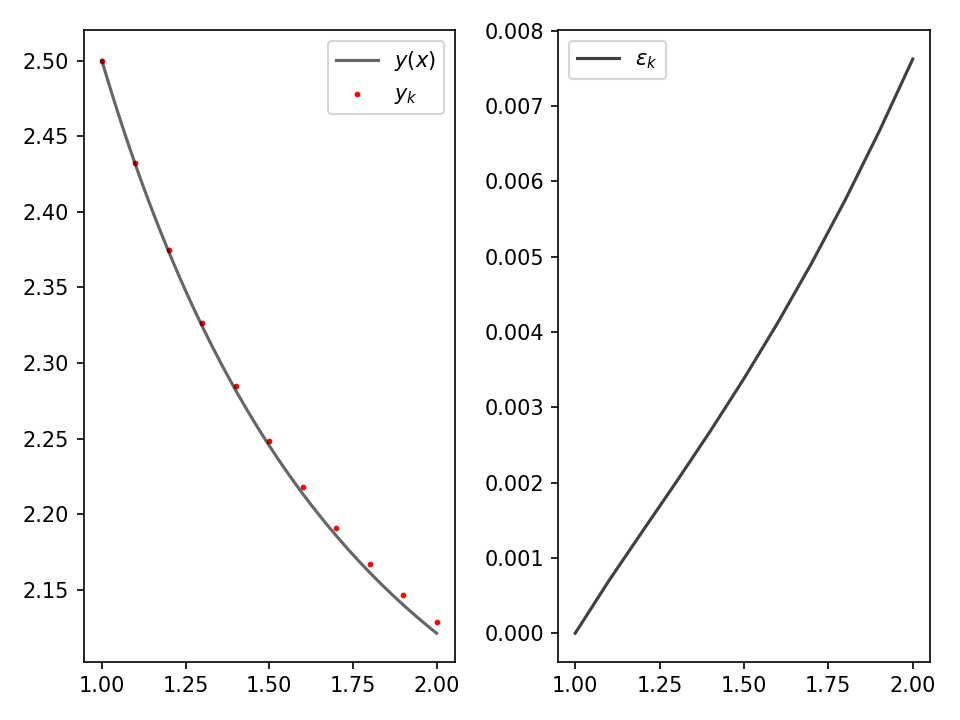

In [9]:
Y1 = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'first order')
plot_results(X, Y1, y_true)

<IPython.core.display.Javascript object>


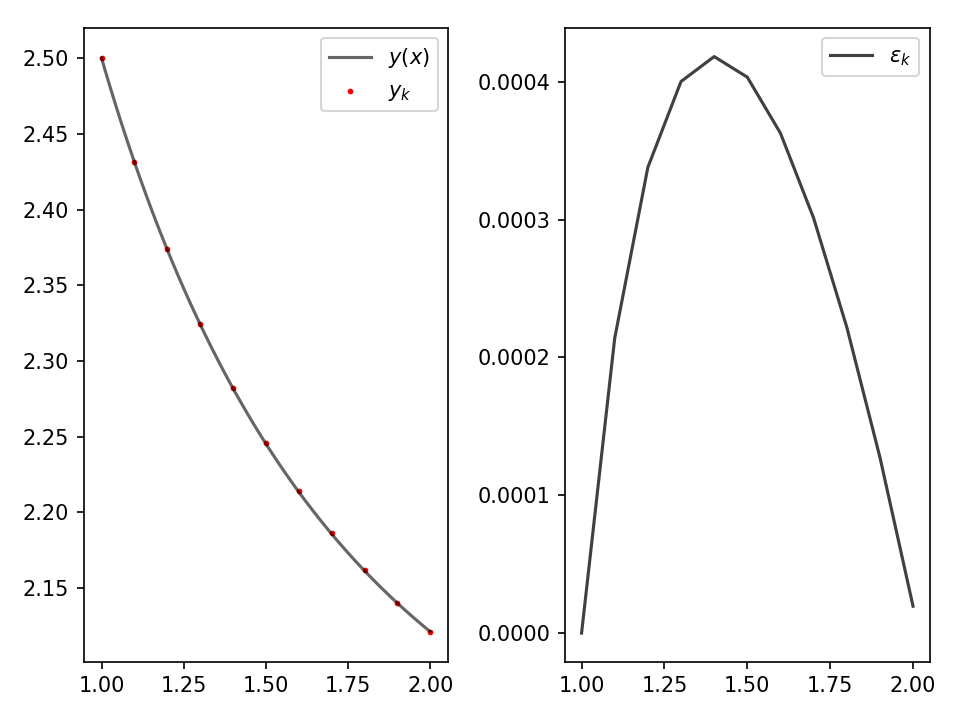

In [10]:
Y2 = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'second order')
plot_results(X, Y2, y_true)

<IPython.core.display.Javascript object>


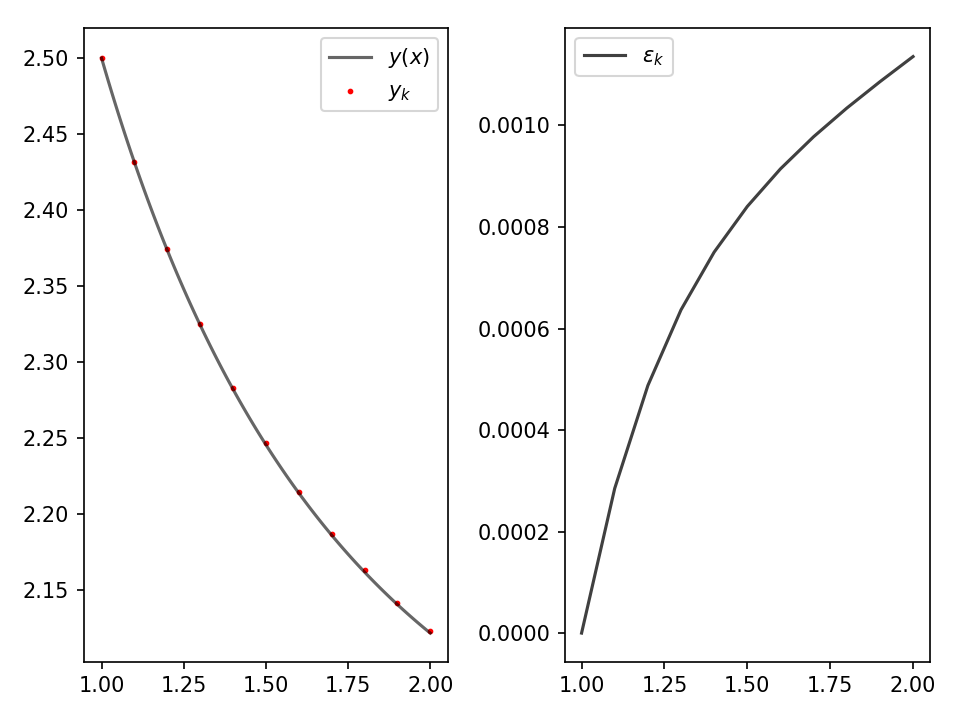

In [11]:
Y3 = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'second order taylor')
plot_results(X, Y3, y_true)

In [12]:
display_results_table(y_true, p0, p1, p2, f, bcs, a, b, N)

Способ аппроксимации краевых условий,1 способ,2 способ,3 способ
$x_k$,,,
1.0,2.5,2.5,2.5
1.1,2.43203,2.43154,2.43161
1.2,2.37482,2.3738,2.37395
1.3,2.32622,2.3246,2.32484
1.4,2.2846,2.28233,2.28267
1.5,2.24875,2.24577,2.24621
1.6,2.21772,2.21396,2.21451
1.7,2.19076,2.18615,2.18683
1.8,2.16729,2.16175,2.16257


In [ ]:
p0 = lambda x: 4*x**2
p1 = lambda x: -4*x
p2 = lambda x: -5
f  = lambda x: -4*x**.5

x = linspace(a, b, N+1)

alpha0, alpha1, A = 2, 0, 5
beta0, beta1, B = 1, 4, 2**0.5
# boundary conditions all together
bcs = {'alpha0': alpha0, 'alpha1': alpha1, 'A': A,
       'beta0':   beta0, 'beta1':   beta1, 'B': B}

In [ ]:
def solve_2linbvp(p0, p1, p2, f, x, bcs, ret_coefs=False):
    P0, P1, P2, F = p0(x), p1(x), p2(x), f(x)
    alpha0 = bcs['alpha0']; alpha1 = bcs['alpha1']; A = bcs['A']
    beta0 = bcs['beta0']; beta1 = bcs['beta1']; B = bcs['B']
    
    

# Контрольные примеры

In [26]:
p0 = 2*x + 1
p1 = 2*x - 1
p2 = sympify(-2)
f = x*(x+1)
a, b, N = 0, 1, 10
alpha0, alpha1, A = 1, 0, 0.5
beta0, beta1, B = 1, 1, 5

bcs = {'alpha0': alpha0, 'alpha1': alpha1, 'A': A,
       'beta0':   beta0, 'beta1':   beta1, 'B': B}

y_true = exp(-x) + 1/2 * (x**2+4*x-1)
X = linspace(a, b, N+1)

In [ ]:
display_results_table(y_true, p0, p1, p2, f, bcs, a, b, N)

In [27]:
p0 = x**2
p1 = -x
p2 = sympify(-3)
f = x**4

a, b, N = 1, 2, 4

alpha0, alpha1, A = 1, 0, 0
beta0, beta1, B = 1, 2, 1
bcs = {'alpha0': alpha0, 'alpha1': alpha1, 'A': A,
       'beta0':   beta0, 'beta1':   beta1, 'B': B}

y_true = (43 - 75*x**4 + 32*x**5) / (160*x)
X = linspace(a, b, N+1)

[[ 0.       0.25     0.     ]
 [ 1.71875 -3.3125   1.40625]
 [ 2.4375  -4.6875   2.0625 ]
 [ 3.28125 -6.3125   2.84375]
 [-2.       2.25     0.     ]] [ 0.          0.15258789  0.31640625  0.58618164  0.25      ]


<IPython.core.display.Javascript object>


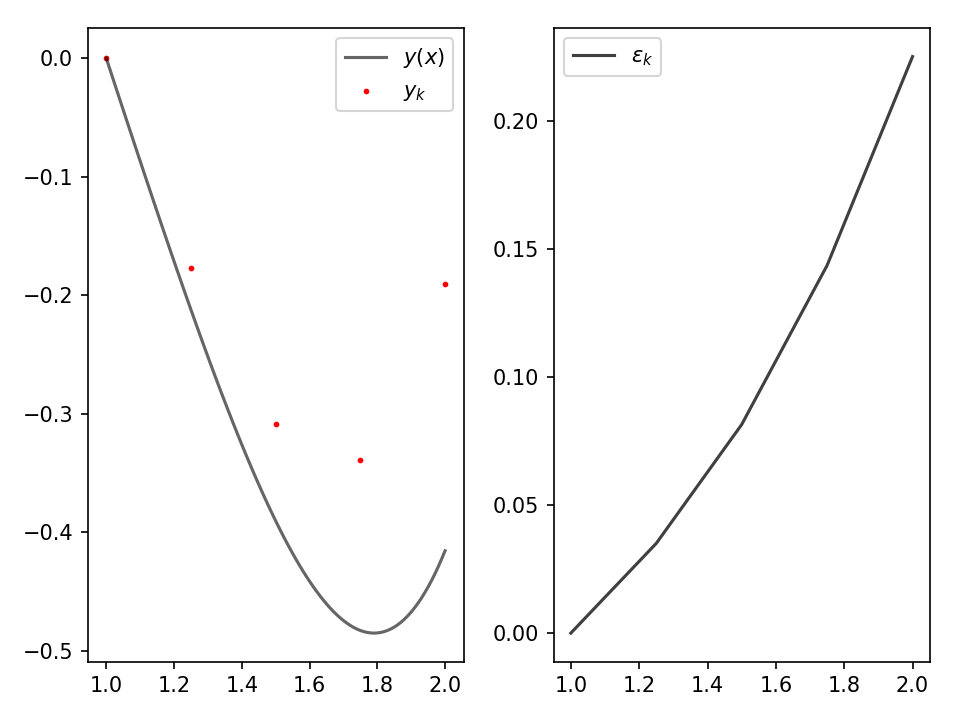

In [28]:
Y, coefs, rhs = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'first order', ret_coefs=True)

print(coefs, rhs)
plot_results(X, Y, y_true)

[[ 0.          0.5         0.        ]
 [ 1.71875    -3.3125      1.40625   ]
 [ 2.4375     -4.6875      2.0625    ]
 [ 3.28125    -6.3125      2.84375   ]
 [-4.15238095  4.76666667  0.        ]] [ 0.          0.15258789  0.31640625  0.58618164  0.14270833]


<IPython.core.display.Javascript object>


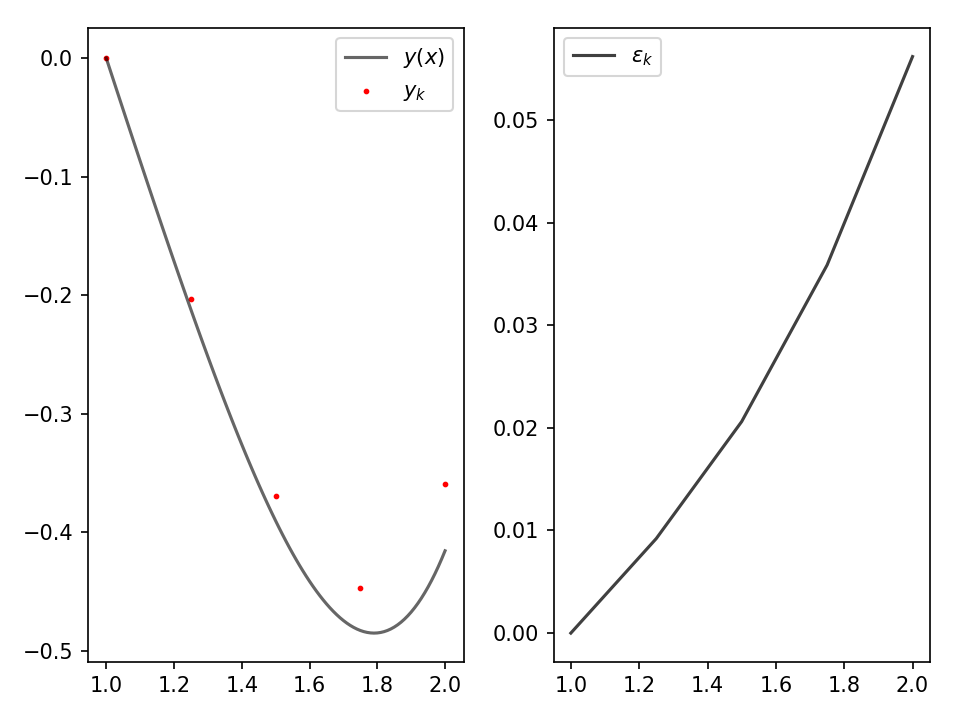

In [29]:
Y, coefs, rhs = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'second order', ret_coefs=True)

print(coefs, rhs)
plot_results(X, Y, y_true)

[[  0.        1.        0.     ]
 [  1.71875  -3.3125    1.40625]
 [  2.4375   -4.6875    2.0625 ]
 [  3.28125  -6.3125    2.84375]
 [-34.       38.75      0.     ]] [ 0.          0.15258789  0.31640625  0.58618164  0.        ]


<IPython.core.display.Javascript object>


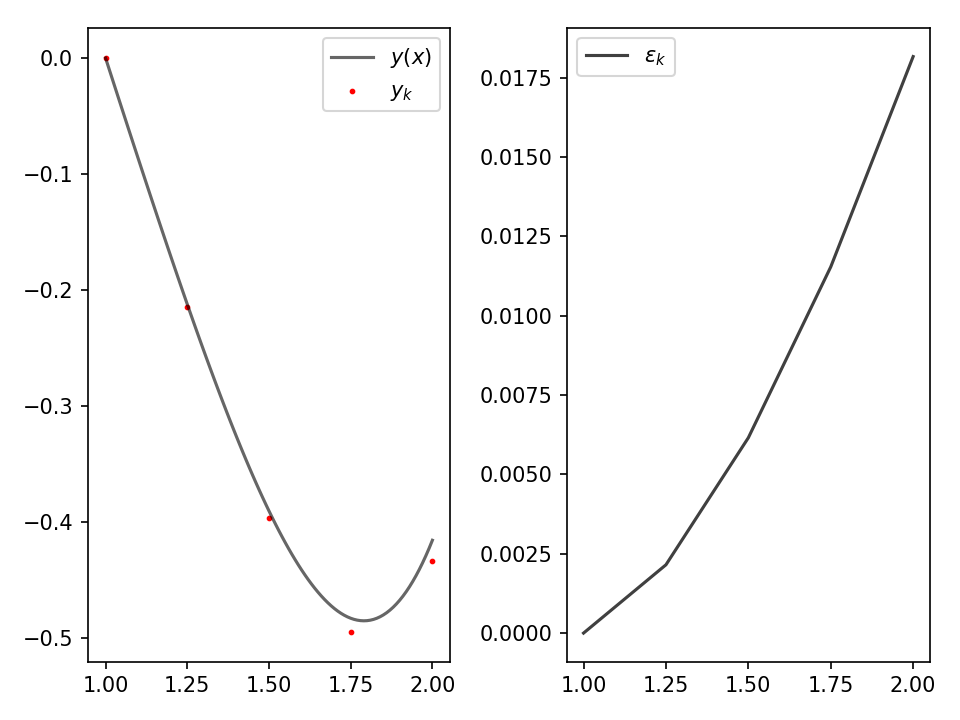

In [30]:
Y, coefs, rhs = solve_linear_2nd_order_de(p0, p1, p2, f, bcs, a, b, N, 'second order taylor', ret_coefs=True)

print(coefs, rhs)
plot_results(X, Y, y_true)

In [31]:
display_results_table(y_true, p0, p1, p2, f, bcs, a, b, N)

Способ аппроксимации краевых условий,1 способ,2 способ,3 способ
$x_k$,,,
1.0,-4.74368e-17,-1.81673e-17,-2.22045e-17
1.25,-0.177194,-0.203034,-0.214398
1.5,-0.308884,-0.369751,-0.396519
1.75,-0.339189,-0.446985,-0.494392
2.0,-0.19039,-0.359443,-0.433789
$\max \varepsilon_i$,2.25e-01,5.62e-02,1.82e-02
